In [1]:
# Step 1 : Train baseline and robust models 
# Step 2 : Compute counterfactuals for both the models. 
# Step 3 : Comparison study between the two.


In [2]:
# import recourse
# from recourse.cplex_helper import DEFAULT_CPLEX_PARAMETERS

In [3]:
# %pip install mip



In [3]:
import sys
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/")
sys.path.append("/Users/skrishna/Documents/phd_codes/neurips_paper/")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/Generative_Model")


sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR/recourse/")


In [4]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn as nn

import ML_Models.data_loader as loader
# from Recourse_Methods.gradient_methods import SCFE
# from utils import get_recourses, get_performance_measures


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [11]:
## Dataset Prep


from torchvision import  datasets, transforms
from torch.utils.data import DataLoader

data_name = "compas"
n_starting_instances = 1200
compas_dict = {
        "data_path": '../Data_Sets/COMPAS/',
        "filename_train": 'compas-train.csv',
        "filename_test": 'compas-test.csv',
        "label": "risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }

adult_dict = {
        "data_path": "../Data_Sets/Adult/",
        "filename_train": 'adult-train.csv',
        "filename_test": 'adult-test.csv',
        "label": 'income',
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 25,
        "H2": 25,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }


data_meta_dictionaries = {
        "compas": compas_dict, 
        "adult": adult_dict
    }
data_meta_info = data_meta_dictionaries[data_name]


dataset_test = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                 filename=data_meta_info["filename_test"],
                                                 label=data_meta_info["label"])
        
dataset_train = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                  filename=data_meta_info["filename_train"],
                                                  label=data_meta_info["label"])


In [12]:
# Data loader

train_loader = DataLoader(dataset_train, batch_size = 32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size = 32, shuffle=False)

In [43]:

model = torch.load("./models/{}_lr_model.pth".format(data_name))
model_robust = torch.load("./models/{}_lr_model_robust.pth".format(data_name))



In [44]:
model

Linear(in_features=7, out_features=1, bias=True)

In [47]:
# # Single pass over data 
# # do a single pass over the data
# def epoch(loader, model, opt=None):
#     total_loss, total_err = 0.,0.
#     for X,y,ind in loader:
#         X = X.to(torch.float32)
#         yp = model(X)[:,0]
#         loss = nn.BCEWithLogitsLoss()(yp, y.float())
#         if opt:
#             opt.zero_grad()
#             loss.backward()
#             opt.step()
        
#         total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
#         total_loss += loss.item() * X.shape[0]
#     return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# model = nn.Linear(7, 1)
# opt = optim.SGD(model.parameters(), lr=1.)
# print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
# for i in range(80):
#     train_err, train_loss = epoch(train_loader, model, opt)
#     test_err, test_loss = epoch(test_loader, model)
#     print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
    
    

In [48]:
# # Save baseline model
# torch.save(model, "./models/{}_lr_model.pth".format(data_name))


In [14]:
# Specifying \delta
epsilon = 0.2
delta = epsilon * model.weight.detach().sign()


In [15]:
delta

tensor([[ 0.2000, -0.2000, -0.2000, -0.2000, -0.2000,  0.2000, -0.2000]])

In [46]:
# Testing error on adversarial sample 
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X = X.to(torch.float32)
#         tmp = ((2*y.float()-1)[:, None]*delta.squeeze(0)).squeeze(0)
        yp = model(X-((2*y.float()-1)[:, None]*delta.squeeze(0)).squeeze(0)).squeeze(-1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model_robust, delta[None,None,:,:]))



(0.1854251012145749, 0.4801929838502938)


In [49]:
# # Robust model training 
# def epoch_robust(loader, model, epsilon, opt=None):
#     total_loss, total_err = 0.,0.
#     for X,y,ind in loader:
#         X = X.to(torch.float32)
#         yp = model(X)[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
#         loss = nn.BCEWithLogitsLoss()(yp, y.float())
#         if opt:
#             opt.zero_grad()
#             loss.backward()
#             opt.step()
        
#         total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
#         total_loss += loss.item() * X.shape[0]
#     return total_err / len(loader.dataset), total_loss / len(loader.dataset)


# model_robust = nn.Linear(7, 1)
# opt = optim.SGD(model_robust.parameters(), lr=1e-1)
# epsilon = 0.2
# print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
# for i in range(50):
#     train_err, train_loss = epoch_robust(train_loader, model_robust, epsilon, opt)
#     test_err, test_loss = epoch_robust(test_loader, model_robust, epsilon)
#     print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
    
    

In [50]:
# # Save robust model 
# torch.save(model_robust, "./models/{}_lr_model_robust.pth".format(data_name))


In [51]:
# Utils
import torch
import numpy as np
from torch import nn
import datetime


class SCFE:
    
    def __init__(self, classifier, target_threshold: float = 0, _lambda: float = 10.0,
                 lr: float = 0.05, max_iter: int = 500, t_max_min: float = 0.5,
                 step: float = 0.10, norm: int = 1, optimizer: str = 'adam'):
        
        super().__init__()
        self.model_classification = classifier
        self.lr = lr
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.t_max_min = t_max_min
        self.norm = norm
        self.sigmoid = nn.Sigmoid()
        self.target_thres = target_threshold
        self._lambda = _lambda
        self.step = step
    
    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
            query instance: the point to be explained
            target_class: Direction of the desired change. If target_class = 1, we aim to improve the score,
                if target_class = 0, we aim to decrese it (in classification and regression problems).
            _lambda: Lambda parameter (distance regularization) parameter of the problem
        """
        
        if target_class == 1:
            target_prediction = torch.tensor(1).float()
        else:
            target_prediction = torch.tensor(0).float()
        
        output = self._call_model(query_instance.reshape(1, -1))
        
        cf = query_instance.clone().requires_grad_(True)
        
        if self.optimizer == 'adam':
            optim = torch.optim.Adam([cf], self.lr)
        else:
            optim = torch.optim.RMSprop([cf], self.lr)
        
        # Timer
        t0 = datetime.datetime.now()
        t_max = datetime.timedelta(minutes=self.t_max_min)
        
        counterfactuals = []
        while not self._check_cf_valid(output, target_class):
            
            iter = 0
            distances = []
            all_loss = []
            
            while not self._check_cf_valid(output, target_class) and iter < self.max_iter:
                
                cf.requires_grad = True
                total_loss, loss_distance = self.compute_loss(self._lambda, cf,
                                                              query_instance,
                                                              target_prediction)
                
                optim.zero_grad()
                total_loss.backward(retain_graph=True)
                optim.step()
                
                output = self._call_model(cf)
                
                if self._check_cf_valid(output, target_class):
                    counterfactuals.append(cf.detach())
                    distances.append(loss_distance.clone().detach())
                    all_loss.append(total_loss.detach())
                
                iter = iter + 1
            
            # print('balance parameter: ', self._lambda)
            output = self._call_model(cf).reshape(1, -1).detach()
            if datetime.datetime.now() - t0 > t_max:
                # print('Timeout - No counterfactual explanation found')
                break
            # elif self._check_cf_valid(output, target_class):
                # print('Counterfactual explanation found')

            if self.step == 0.0:  # Don't search over lambdas
                break
            else:
                self._lambda -= self.step

        if not len(counterfactuals):
            print('No CE found')
            cf.detach_()
            return cf, torch.tensor(np.nan)
        
        # Choose the nearest counterfactual
        counterfactuals = torch.stack(counterfactuals)
        distances = torch.stack(distances)
        distances = distances.detach()
        index = torch.argmin(distances)
        counterfactuals = counterfactuals.detach()

        ce_star = counterfactuals[index]
        distance_star = distances[index]
        
        
        return ce_star, distance_star
    
    def compute_loss(self, _lambda: float, cf_candidate: torch.tensor, original_instance: torch.tensor,
                     target: torch.tensor) -> torch.tensor:
        output = self._call_model(cf_candidate)
        # classification loss
        bce_loss = nn.BCEWithLogitsLoss()
#         print("Testing code : " , output, target)
        loss_classification = bce_loss(output, target)
        # distance loss
        loss_distance = torch.norm((cf_candidate - original_instance), self.norm)
        # full loss
        total_loss = loss_classification + _lambda * loss_distance
        return total_loss, loss_distance

    def _call_model(self, cf_candidate):
        output = self.model_classification(cf_candidate)[0]
        return output

    def _check_cf_valid(self, output, target_class):
        """ Check if the output constitutes a sufficient CF-example.
            target_class = 1 in general means that we aim to improve the score,
            whereas for target_class = 0 we aim to decrese it.
        """
        if target_class == 1:
            check = output >= self.target_thres
            return check
        else:
            check = output <= self.target_thres
            return check

In [53]:
def _get_input_subset(model_sub, inputs: torch.tensor,
                      subset_size: int = 100,
                      decision_threshold: float = 0) -> torch.tensor:
    
    """
    Get negatively classified inputs & return their predictions
    """
    
    yhat = (model_sub(inputs) > decision_threshold) * 1
    check = (model_sub(inputs) < decision_threshold).detach().numpy()
    selected_indices = np.where(check)[0]
    input_subset = inputs[selected_indices]
    predicted_label_subset = yhat[selected_indices]
    return input_subset[0:subset_size, :], predicted_label_subset[0:subset_size]


In [52]:
def get_counter_factuals(input_data, model_inp , scfe):
    distances = []
    for i in range(inputs.shape[0]):
        print(i)
        counterfactual, distance = scfe.generate_counterfactuals(
                    query_instance=torch.tensor(inputs[i]).reshape(-1),
                    target_class=1 ) 
        distances.append(distance)
    return distances
    
    
### Plot 1 : Box plot for baseline and robust models for distance, and validity. 

inputs = torch.stack([j for i in test_loader for j in torch.unbind(i[0].to(torch.float32))][:50])

scfe = SCFE(classifier=model, lr=1e-3, _lambda=0.00, step=0.00, max_iter=10000)
scfe2 = SCFE(classifier=model_robust, lr=1e-3, _lambda=0.00, step=0.00, max_iter=100000)

distances = get_counter_factuals(inputs, model , scfe)
distances_ro = get_counter_factuals(inputs, model_robust , scfe2)
distances_item_ro = [i.item() for i in distances_ro] 
distances_item = [i.item() for i in distances] 
base_df = pd.DataFrame([(i, j) for i,j in zip(distances_item, ["base"]*len(distances_item))], columns = ["cost", "method"])
ro_df = pd.DataFrame([(i, j) for i,j in zip(distances_item_ro, ["robust"]*len(distances_item_ro))], columns = ["cost", "method"])
distance_df = pd.concat([base_df, ro_df])

    
    

0
1
No CE found
2
No CE found
3
No CE found
4
No CE found
5
No CE found
6
No CE found
7
No CE found
8
No CE found
9
10
No CE found
11
No CE found
12
13
No CE found
14
No CE found
15
No CE found
16
No CE found
17
No CE found
18
19
No CE found
20
No CE found
21
No CE found
22
No CE found
23
No CE found
24
No CE found
25
No CE found
26
No CE found
27
No CE found
28
No CE found
29
No CE found
30
No CE found
31
No CE found
32
No CE found
33
34
No CE found
35
No CE found
36
No CE found
37
No CE found
38
No CE found
39
No CE found
40
41
No CE found
42
No CE found
43
No CE found
44
45
No CE found
46
No CE found
47
No CE found
48
No CE found
49
No CE found
0
No CE found
1
No CE found
2
No CE found
3
No CE found
4
No CE found
5
No CE found
6
No CE found
7
No CE found
8
No CE found
9
No CE found
10
No CE found
11
No CE found
12
No CE found
13
No CE found
14
No CE found
15
No CE found
16
No CE found
17
No CE found
18
No CE found
19
No CE found
20
No CE found
21
No CE found
22
No CE found
23
No CE 

/var/folders/kp/0wxv5tl156vgbnlj8jqt9b7m0000gn/T/ipykernel_33175/2675955465.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_instance=torch.tensor(inputs[i]).reshape(-1),


In [20]:
## CCHVAE
import Recourse_Methods.Generative_Model.model as model_vae
from numpy import linalg as LA

# Second class of counter-factual explanation methods         
class CCHVAE:

    def __init__(self, classifier, model_vae, target_threshold: float = 0,
                 n_search_samples: int = 1000, p_norm: int = 1,
                 step: float = 0.05, max_iter: int = 1000, clamp: bool = True):
        
        super().__init__()
        self.classifier = classifier
        self.generative_model = model_vae
        self.n_search_samples = n_search_samples
        self.p_norm = p_norm
        self.step = step
        self.max_iter = max_iter
        self.clamp = clamp
        self.target_treshold = target_threshold

    def hyper_sphere_coordindates(self, instance, high, low):
    
        """
        :param n_search_samples: int > 0
        :param instance: numpy input point array
        :param high: float>= 0, h>l; upper bound
        :param low: float>= 0, l<h; lower bound
        :param p: float>= 1; norm
        :return: candidate counterfactuals & distances
        """
    
        delta_instance = np.random.randn(self.n_search_samples, instance.shape[1])
        dist = np.random.rand(self.n_search_samples) * (high - low) + low  # length range [l, h)
        norm_p = LA.norm(delta_instance, ord=self.p_norm, axis=1)
        d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
        delta_instance = np.multiply(delta_instance, d_norm)
        candidate_counterfactuals = instance + delta_instance
    
        return candidate_counterfactuals, dist

    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
        :param instance: np array
        :return: best CE
        """  #

        # init step size for growing the sphere
        low = 0
        high = low + self.step

        # counter
        count = 0
        counter_step = 1
        query_instance = query_instance.detach().numpy()

        # get predicted label of instance
        self.classifier.eval()
        instance_label = 1 - target_class
        # vectorize z
        z = self.generative_model.encode_csearch(torch.from_numpy(query_instance).float()).detach().numpy()
        z_rep = np.repeat(z.reshape(1, -1), self.n_search_samples, axis=0)

        while True:
            count = count + counter_step
            print(count)

            if count > self.max_iter:
                candidate_counterfactual_star = np.empty(query_instance.shape[0], )
                candidate_counterfactual_star[:] = np.nan
                distance_star = np.nan
                print('No CE found')
                break

            # STEP 1 -- SAMPLE POINTS on hypersphere around instance
            latent_neighbourhood, _ = CCHVAE.hyper_sphere_coordindates(self, z_rep, high, low)

            x_ce = self.generative_model.decode_csearch(torch.from_numpy(latent_neighbourhood).float()).detach().numpy()

            if self.clamp:
                x_ce = x_ce.clip(-1, 1)

            # STEP 2 -- COMPUTE l1 & l2 norms
            if self.p_norm == 1:
                distances = np.abs((x_ce - query_instance)).sum(axis=1)
            elif self.p_norm == 2:
                distances = LA.norm(x_ce - query_instance, axis=1)
            else:
                print('Distance not defined yet')
            
            # counterfactual labels
            y_candidate = np.argmax(self.classifier(torch.from_numpy(x_ce).float()).detach().numpy(), axis=1)

            indeces = np.where(y_candidate != instance_label)[0]
            candidate_counterfactuals = x_ce[indeces]
            candidate_dist = distances[indeces]

            if len(candidate_dist) == 0:  # no candidate found & push search range outside
                low = high
                high = low + self.step
            elif len(candidate_dist) > 0:  # certain candidates generated
                min_index = np.argmin(candidate_dist)
                candidate_counterfactual_star = candidate_counterfactuals[min_index]
                distance_star = np.abs(candidate_counterfactual_star - query_instance).sum()
                # print('CE found')
                break

        return torch.tensor(candidate_counterfactual_star), torch.tensor(distance_star)
    
    
    

In [109]:
# Load the VAEs

vae_path = "../Recourse_Methods/Generative_Model/Saved_Models/"

input_size = dataset_train.get_number_of_features()

vae_model = model_vae.VAE_model(input_size,
                                data_meta_info['activFun'],
                                data_meta_info['d'],
                                data_meta_info['H1'],
                                data_meta_info['H2'])

data_meta_info["vae_path"] = vae_path + f"vae_{data_name}.pt"

vae_model.load_state_dict(torch.load(data_meta_info["vae_path"]))
        
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=True)
        
trainloader = DataLoader(dataset_train,
                         batch_size=data_meta_info["n_starting_instances"],
                         shuffle=True)


# This method makes the "Manifold assumption" and uses random search in latent space
cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=0.01, max_iter=10000, target_threshold=0)
cchvae2 = CCHVAE(classifier=model_robust, model_vae=vae_model, step=0.01, max_iter=10000, target_threshold=0)



In [110]:


inputs = [i[0] for i in trainloader ]

print(inputs[0][0].shape)


torch.Size([13])


In [21]:
inputs = [i[0] for i in trainloader ]

counterfactual, distance = cchvae.generate_counterfactuals(
                    query_instance=torch.tensor(inputs[0][0].to(torch.float32)).reshape(-1),
                    target_class=1- int(model(inputs[0][0].to(torch.float32)) > 0) )


NameError: name 'trainloader' is not defined

In [104]:
distance

tensor(2.1785)

In [83]:
counterfactual

tensor([-0.2985, -0.7634,  0.2287, -0.9872, -0.9978, -0.1233,  1.0000,  0.3668,
        -0.9979,  0.1331, -1.0000,  0.8590,  0.9995])

In [ ]:
input_size = dataset_test.get_number_of_features()




In [35]:
def get_counter_factuals(input_data, model_inp , scfe):
    distances = []
    for i in range(inputs.shape[0]):
        print(i)
        counterfactual, distance = scfe.generate_counterfactuals(
                    query_instance=torch.tensor(inputs[i]).reshape(-1),
                    target_class=1 ) 
        distances.append(distance)
    return distances
    

In [36]:
# Step 2 : Generate counter-factuals for baseline and robust model
# Step 3 : Compute metrics for validity, cost and robustness

# Validity : count how often the class successfully flipped from negative to positive
# 

In [37]:
### Plot 1 : Box plot for baseline and robust models for distance, and validity. 

inputs = torch.stack([j for i in test_loader for j in torch.unbind(i[0].to(torch.float32))][:200])

scfe = SCFE(classifier=model, lr=1e-3, _lambda=0.00, step=0.00, max_iter=10000)
scfe2 = SCFE(classifier=model_robust, lr=1e-3, _lambda=0.00, step=0.00, max_iter=100000)

distances = get_counter_factuals(inputs, model , scfe)
distances_ro = get_counter_factuals(inputs, model_robust , scfe2)
distances_item_ro = [i.item() for i in distances_ro] 
distances_item = [i.item() for i in distances] 
base_df = pd.DataFrame([(i, j) for i,j in zip(distances_item, ["base"]*len(distances_item))], columns = ["cost", "method"])
ro_df = pd.DataFrame([(i, j) for i,j in zip(distances_item_ro, ["robust"]*len(distances_item_ro))], columns = ["cost", "method"])
distance_df = pd.concat([base_df, ro_df])



0
1
No CE found
2
No CE found
3
No CE found
4
No CE found
5
No CE found
6
No CE found
7
No CE found
8
No CE found
9
10
No CE found
11
No CE found
12
13
No CE found
14
No CE found
15
No CE found
16
No CE found
17
No CE found
18
19
No CE found
20
No CE found
21
No CE found
22
No CE found
23
No CE found
24
No CE found
25
No CE found
26
No CE found
27
No CE found
28
No CE found
29
No CE found
30
No CE found
31
No CE found
32
No CE found
33
34
No CE found
35
No CE found
36
No CE found
37
No CE found
38
No CE found
39
No CE found
40
41
No CE found
42
No CE found
43
No CE found
44
45
No CE found
46
No CE found
47
No CE found
48
No CE found
49
No CE found
50
No CE found
51
No CE found
52
No CE found
53
No CE found
54
55
56
No CE found
57
No CE found
58
No CE found
59
No CE found
60
No CE found
61
62
No CE found
63
64
No CE found
65
No CE found
66
No CE found
67
No CE found
68
No CE found
69
No CE found
70
No CE found
71
No CE found
72
No CE found
73
No CE found
74
No CE found
75
No CE found
76

/var/folders/kp/0wxv5tl156vgbnlj8jqt9b7m0000gn/T/ipykernel_33175/1774677627.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_instance=torch.tensor(inputs[i]).reshape(-1),


90
No CE found
91
No CE found
92
No CE found
93
No CE found
94
No CE found
95
No CE found
96
No CE found
97
No CE found
98
No CE found
99
No CE found
100
No CE found
101
No CE found
102
No CE found
103
No CE found
104
No CE found
105
No CE found
106
107
No CE found
108
No CE found
109
No CE found
110
No CE found
111
No CE found
112
No CE found
113
No CE found
114
No CE found
115
116
No CE found
117
No CE found
118
No CE found
119
No CE found
120
No CE found
121
No CE found
122
No CE found
123
No CE found
124
No CE found
125
No CE found
126
No CE found
127
No CE found
128
No CE found
129
No CE found
130
No CE found
131
No CE found
132
No CE found
133
No CE found
134
No CE found
135
No CE found
136
No CE found
137
No CE found
138
No CE found
139
No CE found
140
141
142
No CE found
143
144
No CE found
145
No CE found
146
No CE found
147
No CE found
148
No CE found
149
No CE found
150
No CE found
151
No CE found
152
No CE found
153
No CE found
154
No CE found
155
No CE found
156
No CE foun

In [34]:
distance_df

,cost,method
0,1.339203,base
1,1.527046,base
2,0.500411,base
3,0.257575,base
4,1.534922,base
...,...,...
195,387.777252,robust
196,389.000458,robust
197,387.823212,robust
198,388.854340,robust


In [91]:
### Plot 1 : Box plot for baseline and robust models for distance, and validity. 

inputs = torch.stack([j for i in test_loader for j in torch.unbind(i[0].to(torch.float32))][:200])


cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=0.01, max_iter=1000000, target_threshold=0)
cchvae2 = CCHVAE(classifier=model_robust, model_vae=vae_model, step=0.01, max_iter=1000000, target_threshold=0)

distances = []
distances_ro = []
distances = get_counter_factuals(inputs, model , cchvae)
distances_ro = get_counter_factuals(inputs, model_robust , cchvae2)
distances_item_ro = [i.item() for i in distances_ro] 
distances_item = [i.item() for i in distances] 
base_df = pd.DataFrame([(i, j) for i,j in zip(distances_item, ["base"]*len(distances_item))], columns = ["cost", "method"])
ro_df = pd.DataFrame([(i, j) for i,j in zip(distances_item_ro, ["robust"]*len(distances_item_ro))], columns = ["cost", "method"])
distance_df = pd.concat([base_df, ro_df])





0


/var/folders/wx/p5_29wbn6fj32m0h0mc8lcp00000gq/T/ipykernel_2900/769919737.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_instance=torch.tensor(inputs[i]).reshape(-1),


KeyboardInterrupt: 

In [87]:
len(distances)

200

In [88]:
len(distances_ro)

200

In [46]:
distance_df.to_csv("adult_cost_lr_scfe.csv")

In [56]:
distance_df = pd.read_csv("adult_cost_lr_scfe.csv")

processing .. robust
processing .. base
Model: robust, Mean_1=388.041, median=387.840
Model: base, Mean_1=0.790, median=0.691


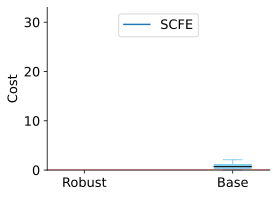

In [33]:
## Plotting code ####

import os
import ipdb
import glob
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 13})  # , 'font.weight': 'bold'})
# plt.rc('font', family='sans-serif')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color='black')
# plt.rc('font', family='sans-serif')


# inits
algos = ['robust', 'base'] #, 'itg', 'sg005', 'shap', 'lime005', 'control'] #, 'pgmex', 'pgex']  # , 'gnnex', 'pgmex', 'pgex']

datasets =   ["comp2"] #,"compas"]
# bernoullis = ["0.03"] #, "0.1"]
# variances =  ["0.05"] #, "0.1"]
# model_name = "ann" #need change for different models

stability_notions = ["SCFE"] #, "stability2_diff_representation", "stability2_diff_output"] #["stability2_diff_input", "stability2_diff_representation", "stability2_diff_output"]

for data_name in datasets:
    plt.figure(figsize=(4, 3))
    plot_names = ["SCFE"] #, "ROS", "RRS"]
    plot_cols = ["skyblue"] #, "green", "orange"]
    plots = []
    tick_val= 0
    for stab_ind,stability_notion in enumerate(stability_notions):

        df = distance_df 
        df_sep = []

        for i, val in enumerate(algos):
            print("processing ..", val)
            df_sep.append(df[df["method"] == val]["cost"].to_numpy())


        ## print statistics
        for i, val in enumerate(df_sep):
            print(f'Model: {algos[i]}, Mean_1={np.mean(val):.3f}, median={np.median(df_sep[i]):.3f}')

        
        val = plt.boxplot(df_sep, positions=np.array(range(len(df_sep)))*2.0+tick_val, sym='', widths=0.5, patch_artist=True) #, boxprops=dict(facecolor='skyblue'))
        tick_val+=1
        plt.plot([], label=plot_names[stab_ind])
        set_box_color(val, plot_cols[stab_ind])
        
        
    #plt.legend(loc="center bottom")
    plt.legend(loc='upper center', ncol=2)
    plt.xticks(np.array(range(len(df_sep)))*2.0, ['Robust', 'Base']) #, 'Input*Grad', 'SmoothGrad', 'SHAP', 'LIME', 'RandomBaseline'])
    plt.ylim(0, 33)
    plt.axhline(y=0, color='red', linewidth= 0.8)
    plt.ylabel("Cost")
    plt.savefig("./plots/"+data_name+"_"+plot_names[stab_ind]+".png",  bbox_inches='tight')
    
        
        
        


 

In [28]:
!pip install ipdb

  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11646 sha256=290e38c46646aa12a4ace0da055c2d30bfc46acee86c490dd50564c72749c1f1
  Stored in directory: /Users/satyaprk/Library/Caches/pip/wheels/f7/29/9a/cf774cd86e9802f075a0be1c9e0830bc062d07897b2e9e87cd
Successfully built ipdb
